# Convolutional Neural Networks Part 2:

 - Methods To Handle Overfitting

### 1st Method: Image-Data Augmentation Only:

### Sources:

 - https://keras.io/applications/
 - https://towardsdatascience.com/deep-learning-3-more-on-cnns-handling-overfitting-2bd5d99abe5d
 - https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/
 - https://neurohive.io/en/popular-networks/vgg16/
 - https://www.dlology.com/blog/one-simple-trick-to-train-keras-model-faster-with-batch-normalization/
 - https://github.com/Xinyi6/CIFAR10-CNN-by-Keras/blob/master/doc/CIFAR10%20CNN%20use%20Keras.pdf
 - https://github.com/moritzhambach/Image-Augmentation-in-Keras-CIFAR-10-/blob/master/CNN%20with%20Image%20Augmentation%20(CIFAR10).ipynb

#### Turn Off Messages:

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Fix: UnknownError: Failed to get convolution algorithm. 
# This is probably because cuDNN failed to initialize, 
# so try looking to see if a warning log message was printed above
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

#### Check GPU Availibility & Set Memory Limit:

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)]) # Alt: 1792 MB, 2048 MB
    except RuntimeError as e:
        print(e)

tf.config.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### Import Libraries:

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from random import randint
from tensorflow.keras import layers, regularizers
from keras.models import Sequential, load_model
from keras.datasets import cifar10
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from keras.applications.vgg16 import preprocess_input
from keras.layers import Dense, Conv2D, Flatten, Dropout, Activation, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score

#### Define Functions For Plotting:

In [4]:
# plot training accuracy and loss
def plotCurve(trainingAccuracy, trainingLoss):
    epochs = np.arange(trainingLoss.shape[0])
    #print(epochs)
    plt.figure(figsize = [12, 6])
    plt.subplot(1, 2, 1)
    plt.plot(epochs, trainingAccuracy)
    #plt.axis([-1, 2, -1, 2])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, trainingLoss)
    plt.xlabel('Epoch')
    plt.ylabel('Binary CrossEntropy Loss')
    plt.title('Training Loss')
    plt.show()

def accuracyFunc(labelsActual, labelsPred):
    accuracy = (np.sum(labelsActual == labelsPred) / len(labelsActual)) * 100
    return accuracy

# Plot Features of CIFAR-10 data
def feat_plot(features, labels, classes, title):
    for class_i in classes:
        plt.plot(features[labels[:] == classes[class_i], 0],
                 features[labels[:] == classes[class_i], 1], 'o', markersize = 5)
        # plt.axis([-2, 2, -2, 2])
        plt.xlabel('X: Feature 1')
        plt.ylabel('Y: Feature 2')
        plt.title(title)
        plt.legend(['Class ' + str(classes[class_i]) for class_i in classes])
    plt.show()

def plotBothCurves(trainingAccuracy, trainingLoss, validAccuracy, validLoss):
    epochs = np.arange(trainingLoss.shape[0])
    epochsSaved = np.arange(validLoss.shape[0])
    #print(epochs)
    # 1st Subplot: Accuracy
    plt.figure(figsize = [12, 6])
    plt.subplot(1, 2, 1)
    plt.plot(epochs, trainingAccuracy)
    plt.plot(epochsSaved, validAccuracy) # Saved Best Value
    plt.legend(['Training', 'Validation'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    # 2nd Subplot: Training Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, trainingLoss)
    plt.plot(epochsSaved, validLoss)
    plt.legend(['Training', 'Validation'])
    plt.xlabel('Epoch')
    plt.ylabel('Binary CrossEntropy Loss')
    plt.title('Training Loss')
    plt.show()

# Plot CIFAR-10 Data In Subplots
def img_plt(img, label):
    plt.figure(figsize=(12, 5.5))
    for i in range (1, 11):
        plt.subplot(2, 5, i)
        plt.imshow(img[i - 1, :, :], cmap = 'gray')
        plt.title('Label: ' + str(label[i - 1]))
    plt.show()

def plotEverything(model_hist):
    trainAcc = np.array(model_hist.history['accuracy'])
    trainLoss = np.array(model_hist.history['loss'])
    validAcc = np.array(model_hist.history['val_accuracy'])
    validLoss = np.array(model_hist.history['val_loss'])

    plotBothCurves(trainAcc, trainLoss, validAcc, validLoss)

    trainScore = [trainAcc[-1], trainLoss[-1]]
    print(f'\nTraining Accuracy: {round(trainScore[0], 5) * 100} %')
    print(f'Training Loss: {round(trainScore[1], 4)}\n')

    valScore = [validAcc[-1], validLoss[-1]]
    print(f'\nValidation Accuracy: {round(valScore[0], 5) * 100} %')
    print(f'Validation Loss: {round(valScore[1], 4)}\n')

#### Import Data:

 - Each of the 50,000 Images is 32 x 32 pixels x 3 RGB values
     - Each Image is 3D.

In [5]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

classes = np.arange(10)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


#### Randomize & Select 20% of Images For Validation:

In [6]:
num_train_img = x_train.shape[0]
train_ind = np.arange(0, num_train_img)
train_ind_s = np.random.permutation(train_ind)
print(train_ind)
print(train_ind_s, '\n')

x_train = x_train[train_ind_s,:,:,:]
y_train = y_train[train_ind_s]
print(x_train.shape)
print(y_train.shape, '\n')

x_val = x_train[0:int(0.2 * num_train_img),:,:,:]
y_val = y_train[0:int(0.2 * num_train_img)]
print(x_val.shape)
print(y_val.shape, '\n')

x_train = x_train[int(0.2 * num_train_img):,:,:]
y_train = y_train[int(0.2 * num_train_img):]
print(x_train.shape)
print(y_train.shape, '\n')

[    0     1     2 ... 49997 49998 49999]
[ 6320 41093 17208 ... 18548  5302 36789] 

(50000, 32, 32, 3)
(50000, 1) 

(10000, 32, 32, 3)
(10000, 1) 

(40000, 32, 32, 3)
(40000, 1) 



#### Plot 1st 10 Images From Randomized Data:

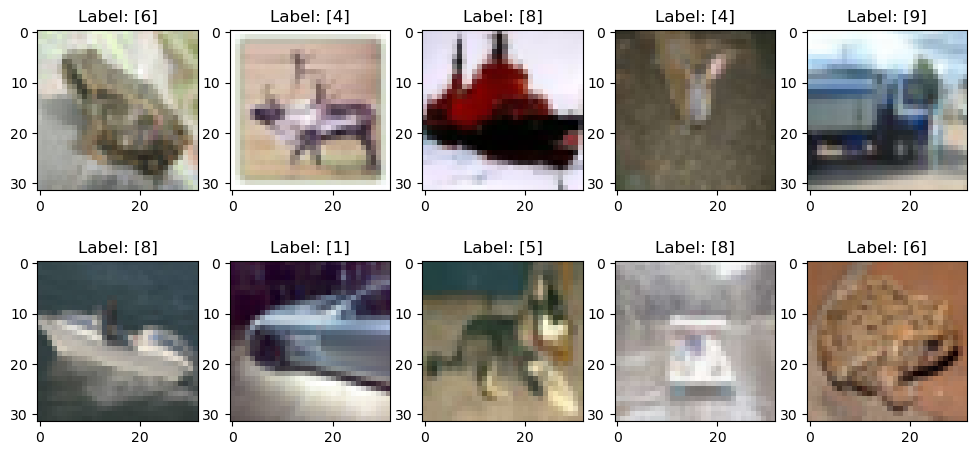

In [7]:
img_plt(x_train[0:10,:,:,:], y_train[0:10]) # plot the images

#### Scaling The Images to $ [0, \ 1] $:

In [8]:
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_val /= 255
x_test /= 255

#### Convert Class Vectors to Binary Class Matrices:

In [9]:
y_train_c = to_categorical(y_train, len(classes))
y_val_c = to_categorical(y_val, len(classes))
y_test_c = to_categorical(y_test, len(classes))

### 1st Method: Image-Data Augmentation Only:

#### Define The Model:

In [10]:
model4 = Sequential()
model4.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', input_shape=x_train.shape[1:]))
model4.add(Activation('relu'))
model4.add(Conv2D(32, (3, 3), padding='same'))
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2))) # MaxPooling2D Layer or AveragePooling2D Layer

model4.add(Conv2D(64, (3, 3), padding='same'))
model4.add(Activation('relu'))
model4.add(Conv2D(64, (3, 3), padding='same'))
model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))

model4.add(Flatten()) # Optional:Flattens 2D images to 1D Array
model4.add(Dense(units=512, activation='relu'))
model4.add(Dropout(0.5)) # Helps to reduce overfitting
model4.add(Dense(units=len(classes), activation='softmax'))
model4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 64)        0

#### Compile The Model:

 - Create A Data Generator For Real-Time Data Augmentation

In [11]:
opt4 = tf.keras.optimizers.Adam(learning_rate=0.001)
model4.compile(loss='categorical_crossentropy', optimizer=opt4, metrics=['accuracy'])

datagen4 = ImageDataGenerator(
    #shear_range = -0.1,
    #zoom_range = -0.1,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

#### Compute Quantities Required For Featurewise Normalization:

 - std deviation, mean & principal components if ZCA Whitening is Applied.

In [12]:
datagen4.fit(x_train)

#### Create A Checkpoint To Save Best Model:

 - Based On Lowest Validation Loss

In [13]:
save_path4 = '../assets/Lecture7/model4_ckpt.h5'
callbacks_save4 = ModelCheckpoint(save_path4, monitor='val_loss', verbose=0, save_best_only=True, save_freq='epoch')

#### Fit The Model Using The Data Generator & Plot Statistics:

Two Methods To Flow The Images:


1. `.flow_from_directory()` Data Generator For Large Datasets:

`image_generator = image.datagen.flow_from_directory('data/images', class_mode=None, seed=seed)`


2. `.flow()` for small datasets loaded into memory:

`model.fit_generator(datagen.flow(x_train, y_train, batch_size=32), steps_per_epoch=len(train) / 32, epochs=epochs`

Epoch 1/50
2500/2500 [==============================] - 30s 10ms/step - loss: 1.8296 - accuracy: 0.3153 - val_loss: 1.2529 - val_accuracy: 0.5504
Epoch 2/50
2500/2500 [==============================] - 22s 9ms/step - loss: 1.2852 - accuracy: 0.5395 - val_loss: 1.0331 - val_accuracy: 0.6260
Epoch 3/50
2500/2500 [==============================] - 21s 9ms/step - loss: 1.1217 - accuracy: 0.6004 - val_loss: 0.9606 - val_accuracy: 0.6594
Epoch 4/50
2500/2500 [==============================] - 21s 8ms/step - loss: 1.0352 - accuracy: 0.6349 - val_loss: 0.9407 - val_accuracy: 0.6699
Epoch 5/50
2500/2500 [==============================] - 22s 9ms/step - loss: 0.9706 - accuracy: 0.6548 - val_loss: 0.8464 - val_accuracy: 0.7015
Epoch 6/50
2500/2500 [==============================] - 22s 9ms/step - loss: 0.9175 - accuracy: 0.6778 - val_loss: 0.7965 - val_accuracy: 0.7209
Epoch 7/50
2500/2500 [==============================] - 22s 9ms/step - loss: 0.9072 - accuracy: 0.6826 - val_loss: 0.8120 - val_a

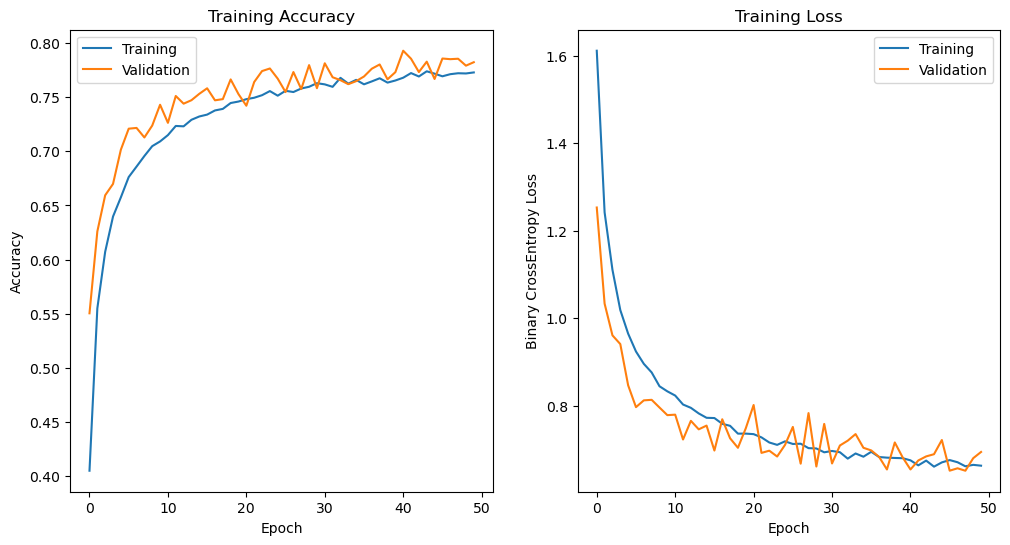


Training Accuracy: 77.285 %
Training Loss: 0.6627


Validation Accuracy: 78.23 %
Validation Loss: 0.6941



In [14]:
history4 = model4.fit(datagen4.flow(x_train, y_train_c, batch_size=16), 
                      steps_per_epoch=len(x_train) / 16, epochs=50, 
                      verbose=1, validation_data=(x_val, y_val_c), 
                      callbacks=[callbacks_save4])

plotEverything(history4)

#### Load Best Model & Evaluate:

In [15]:
model4a = load_model(save_path4)

score4a = model4a.evaluate(x_train, y_train_c)
print(f'Total Loss From Training Set: {score4a[0]}')
print(f'Accuracy From Training Set: {score4a[1]}\n')

score4b = model4a.evaluate(x_val, y_val_c)
print(f'Total Loss From Validation Set: {score4b[0]}')
print(f'Accuracy From Validation Set: {score4b[1]}\n')

score4c = model4a.evaluate(x_test, y_test_c)
print(f'Total Loss From Testing Set: {score4c[0]}')
print(f'Accuracy From Testing Set: {score4c[1]}\n')

1250/1250 [==============================] - 3s 2ms/step - loss: 0.4798 - accuracy: 0.8357
Total Loss From Training Set: 0.47982051968574524
Accuracy From Training Set: 0.8356500267982483

313/313 [==============================] - 1s 4ms/step - loss: 0.6512 - accuracy: 0.7855
Total Loss From Validation Set: 0.6511979699134827
Accuracy From Validation Set: 0.7854999899864197

313/313 [==============================] - 1s 4ms/step - loss: 0.6678 - accuracy: 0.7856
Total Loss From Testing Set: 0.6677590012550354
Accuracy From Testing Set: 0.7856000065803528



#### Predict Class Of Held Out Samples:

In [16]:
test_class1_prob = model4.predict(x_test)
test_labels = np.argmax(test_class1_prob, axis=1)
print(f'The Accuracy Predicting The Test Set is: {accuracy_score(test_labels, y_test) * 100} %\n')
conf_matrix = confusion_matrix(test_labels, y_test)

colLabels = ['Pred Plane', 'Pred Car', 'Pred Bird', 'Pred Cat', 'Pred Deer',
             'Pred Dog', 'Pred Frog', 'Pred Horse', 'Pred Ship', 'Pred Truck']
rowLabels = ['Actual Plane', 'Actual Car', 'Actual Bird', 'Actual Cat', 'Actual Deer',
             'Actual Dog', 'Actual Frog', 'Actual Horse', 'Actual Ship', 'Actual Truck']

fancyMatrix = pd.DataFrame(conf_matrix, columns=colLabels, index=rowLabels,)
display(fancyMatrix)

The Accuracy Predicting The Test Set is: 77.7 %



,Pred Plane,Pred Car,Pred Bird,Pred Cat,Pred Deer,Pred Dog,Pred Frog,Pred Horse,Pred Ship,Pred Truck
Actual Plane,850,2,81,39,32,19,13,22,92,11
Actual Car,31,925,10,23,3,10,15,8,49,58
Actual Bird,24,1,673,58,47,37,26,28,10,5
Actual Cat,8,1,27,512,36,106,25,24,2,4
Actual Deer,5,0,47,50,738,31,21,24,1,0
Actual Dog,3,0,40,128,13,672,13,37,1,0
Actual Frog,6,2,69,93,68,50,864,5,0,1
Actual Horse,3,0,23,35,57,40,5,824,4,2
Actual Ship,21,3,15,10,2,7,9,3,799,6
Actual Truck,49,66,15,52,4,28,9,25,42,913
